# Spatial Modelling of Land Value and Public Transport Accessibility in Prague  

**Vilém Knap**

This notebook provides the first exploratory, map-based inspection of the cleaned datasets produced in `00_Data_Preprocessing.ipynb`.  
The goal is to visually assess (1) spatial patterns in residential land values and (2) the structure of public transport coverage, before introducing any formal spatial diagnostics or modelling assumptions.


## 1. Setup & paths (Code)

In [22]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# --- Paths ---
DATA_DIR = "data/processed"
QC_DIR   = "data/processed/qc"

PRICE_RES_PATH = os.path.join(DATA_DIR, "price_residential_prague_nearest_stops_by_mode.gpkg")

STOPS_TRAM_PATH  = os.path.join(DATA_DIR, "stops_tram.gpkg")
STOPS_METRO_PATH = os.path.join(DATA_DIR, "stops_metro.gpkg")
STOPS_BUS_PATH   = os.path.join(DATA_DIR, "stops_bus.gpkg")
STOPS_RAIL_PATH  = os.path.join(DATA_DIR, "stops_rail.gpkg")

ROUTES_TRAM_PATH  = os.path.join(DATA_DIR, "routes_tram.gpkg")
ROUTES_METRO_PATH = os.path.join(DATA_DIR, "routes_metro.gpkg")
ROUTES_BUS_PATH   = os.path.join(DATA_DIR, "routes_bus.gpkg")
ROUTES_RAIL_PATH  = os.path.join(DATA_DIR, "routes_rail.gpkg")

PRAGUE_BOUNDARY_PATH = os.path.join(DATA_DIR, "prague_boundary.gpkg")

TARGET_CRS = "EPSG:5514"  # S-JTSK / Krovak East North

## 2. Load datasets (Code)

In [23]:
price = gpd.read_file(PRICE_RES_PATH)
boundary = gpd.read_file(PRAGUE_BOUNDARY_PATH)

stops_tram  = gpd.read_file(STOPS_TRAM_PATH)
stops_metro = gpd.read_file(STOPS_METRO_PATH)
stops_bus   = gpd.read_file(STOPS_BUS_PATH)
stops_rail  = gpd.read_file(STOPS_RAIL_PATH)

routes_tram  = gpd.read_file(ROUTES_TRAM_PATH)
routes_metro = gpd.read_file(ROUTES_METRO_PATH)
routes_bus   = gpd.read_file(ROUTES_BUS_PATH)
routes_rail  = gpd.read_file(ROUTES_RAIL_PATH)

# Ensure CRS
for gdf in [price, boundary, stops_tram, stops_metro, stops_bus, stops_rail,
            routes_tram, routes_metro, routes_bus, routes_rail]:
    if gdf.crs is None:
        raise ValueError("A layer has missing CRS. Fix in preprocessing.")
    if gdf.crs.to_string() != TARGET_CRS:
        gdf.to_crs(TARGET_CRS, inplace=True)

print("Loaded:")
print("price polygons:", len(price), "| cols:", len(price.columns))
print("stops (tram/metro/bus/rail):", len(stops_tram), len(stops_metro), len(stops_bus), len(stops_rail))
print("routes (tram/metro/bus/rail):", len(routes_tram), len(routes_metro), len(routes_bus), len(routes_rail))


Loaded:
price polygons: 5728 | cols: 12
stops (tram/metro/bus/rail): 594 120 2820 47
routes (tram/metro/bus/rail): 35 3 286 31


In [24]:
import pandas as pd
# --- Clean and convert price column ---

price = price.copy()

# convert to numeric, coercing errors (e.g. 'N') to NaN
price["CENA_num"] = (
    price["CENA"]
    .astype(str)
    .str.replace(",", ".", regex=False)  # just in case
    .pipe(pd.to_numeric, errors="coerce")
)

print("After numeric conversion:")
print(price["CENA_num"].describe())

print("Missing / invalid prices:", price["CENA_num"].isna().sum())

After numeric conversion:
count      4871.000000
mean      14412.412236
std        7996.151237
min         700.000000
25%        9970.000000
50%       13740.000000
75%       18000.000000
max      102420.000000
Name: CENA_num, dtype: float64
Missing / invalid prices: 857


The land price attribute is stored as a categorical field in the original dataset and includes non-numeric values indicating missing or undefined prices.  
These values are explicitly converted to missing (`NaN`) and excluded from subsequent analysis to ensure numerical consistency.

## 3. Quick sanity checks (Markdown + Code)
### Data sanity checks

The land price attribute in the original dataset is stored as a categorical field and includes non-numeric values indicating missing or undefined prices.  
Before any visual exploration, the price variable is explicitly converted to a numeric representation. Non-numeric values are treated as missing and excluded from subsequent analysis.

In [8]:
import pandas as pd

# --- Clean and convert land price ---
price = price.copy()

price["CENA_num"] = (
    price["CENA"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .pipe(pd.to_numeric, errors="coerce")
)

print("Price (numeric) summary:")
print(price["CENA_num"].describe())

print("Missing / invalid prices:", price["CENA_num"].isna().sum())

# Keep only polygons with valid price
price = price[price["CENA_num"].notna()].copy()

print("Polygons retained after cleaning:", len(price))



Price (numeric) summary:
count      4871.000000
mean      14412.412236
std        7996.151237
min         700.000000
25%        9970.000000
50%       13740.000000
75%       18000.000000
max      102420.000000
Name: CENA_num, dtype: float64
Missing / invalid prices: 0
Polygons retained after cleaning: 4871


## Land prices analysis

### 4.1 Raw distribution of residential land values


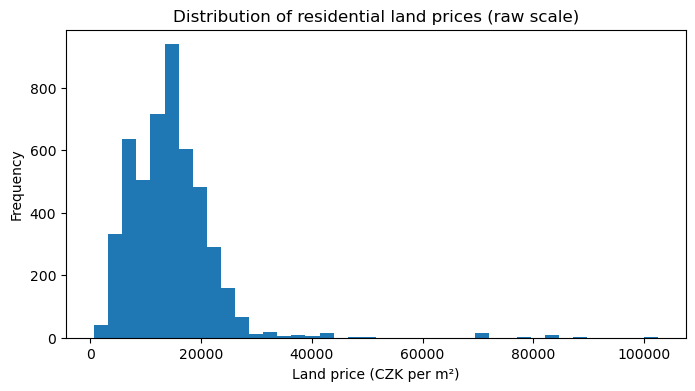

In [14]:
x = price["CENA_num"].to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(x, bins=40)
ax.set_title("Distribution of residential land prices (raw scale)")
ax.set_xlabel("Land price (CZK per m²)")
ax.set_ylabel("Frequency")
plt.show()


The raw distribution of residential land prices is strongly right-skewed.  
Most observations are concentrated at lower price levels, while a small number of polygons exhibit extremely high prices corresponding to central and highly attractive locations.

This long right tail indicates that price variation is multiplicative rather than additive in nature. As a result, extreme values dominate the scale and obscure variation among the majority of observations.


### 4.2 Spatial distribution of residential land values


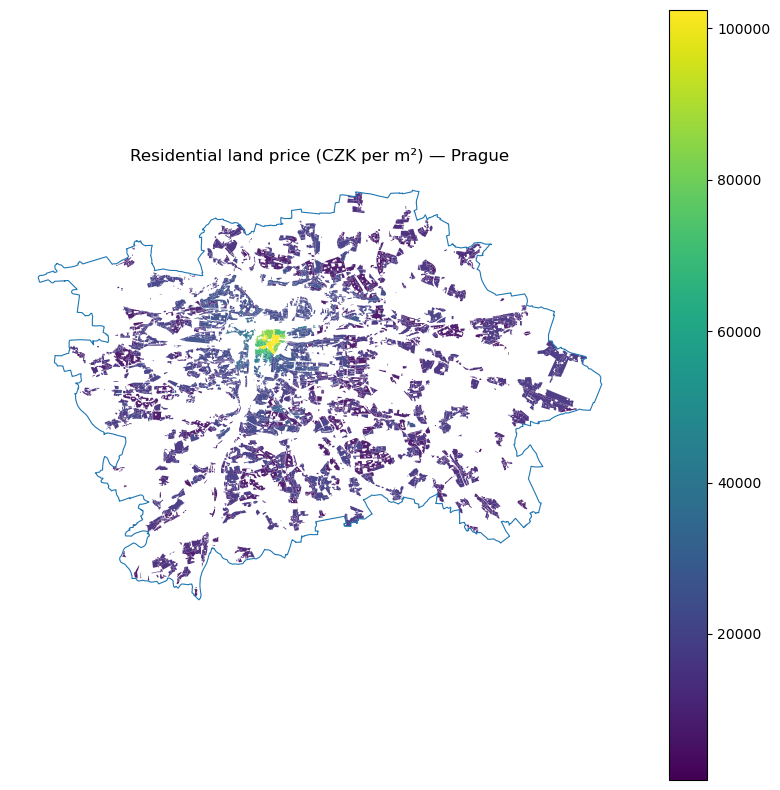

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
boundary.boundary.plot(ax=ax, linewidth=0.8)

price.plot(
    ax=ax,
    column="CENA_num",
    legend=True,
    linewidth=0.0,
    alpha=0.95
)

ax.set_title("Residential land price (CZK per m²) — Prague")
ax.axis("off")
plt.show()

Static plot is not suffecient for thorough visual exploration, geopandas.explore() functionality will allow pan and zoom across map.

In [ ]:
price.explore(
    column="CENA_num",
    cmap="OrRd",
    scheme="quantiles",
    k=7,
    tooltip=["CENA_num", "res_share"],
    legend=True,
    tiles="CartoDB positron",
    style_kwds={"weight": 0.2, "opacity": 0.6},
    name="Residential land price"
)



One can see that the most valuable land is clustered arround historical city center whereas the least prices per square meter can be found on the outskirts of the cities. 

By observing the map, it seems that there is significant cluster of lower value land in the northern part of the city, in the Bohnice Municipality. 

It might correspond with the fact that this part of the city does not have any tram or metro stop nearby and it is available only by bus. This assumption will be further tested.

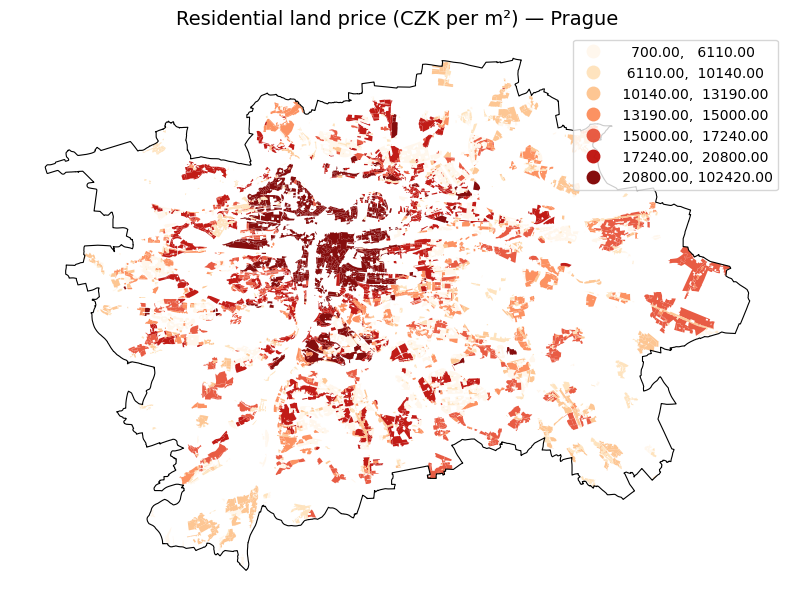

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 1) Plot Prague administrative boundary
boundary.boundary.plot(
    ax=ax,
    linewidth=0.8,
    color="black",
    zorder=2
)

# 2) Plot residential land prices
price.plot(
    ax=ax,
    column="CENA_num",
    cmap="OrRd",
    scheme="quantiles",
    k=7,
    legend=True,
    linewidth=0.0,
    alpha=0.95,
    zorder=1
)

# 3) Final touches
ax.set_title("Residential land price (CZK per m²) — Prague", fontsize=14)
ax.axis("off")

plt.show()


#### Interactive version of the map

In [ ]:
##Adding Prague administrative borders to the map

m = price.explore(
    column="CENA_num",
    cmap="OrRd",
    scheme="quantiles",
    k=7,
    tooltip=["CENA_num", "res_share"],
    legend=True,
    tiles="CartoDB positron",
    style_kwds={"weight": 0.2, "opacity": 0.6},
    name="Residential land price"
)

boundary.explore(
    m=m,
    color="black",
    weight=2,
    fill=False,
    name="Prague boundary"
)




### 4.3 Motivation for logarithmic transformation

Such skewness poses two problems for subsequent analysis.  
First, it reduces the interpretability of visualizations by compressing variation in lower and mid-range prices.  
Second, it violates common modelling assumptions related to homoscedasticity and linear relationships.

To address these issues, a logarithmic transformation of land prices is applied. This transformation preserves relative differences while reducing the influence of extreme values.


Plot in logarithmic scale

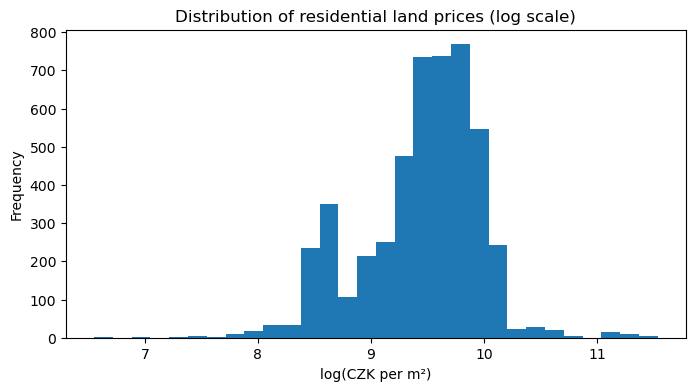

In [15]:
price["log_price"] = np.log(price["CENA_num"])

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(price["log_price"], bins=30)
ax.set_title("Distribution of residential land prices (log scale)")
ax.set_xlabel("log(CZK per m²)")
ax.set_ylabel("Frequency")
plt.show()


After logarithmic transformation, the price distribution becomes substantially more symmetric and closer to a bell-shaped form.  
    
An interesting feature of the log-transformed distribution is a relative gap between approximately 8 and 9 log(CZK per m²), where substantially fewer observations are present.

This pattern likely reflects the administrative, zone-based nature of the land price map rather than a smooth market-driven distribution. 

Certain price levels are simply not represented in the underlying valuation scheme. At the same time, the gap may indicate a structural separation between lower-value peripheral residential areas and higher-value inner-city locations.

At this stage, this observation is treated as exploratory and motivates further spatial analysis rather than a substantive conclusion.


In [ ]:
price["log_price"] = np.log(price["CENA_num"])

price.explore(
    column="log_price",
    cmap="viridis",
    scheme="quantiles",
    k=7,
    tooltip=["CENA_num", "log_price"],
    legend=True,
    tiles="CartoDB positron",
    style_kwds={"weight": 0.2, "opacity": 0.6}
)

The interactive log-price map reveals several notable spatial patterns.

As expected, the historic city core forms a contiguous cluster of the highest land values. In addition to this primary core, a secondary high-value cluster is visible south of the centre, between the districts of Nusle and Krč. This area coincides with major ongoing and planned transport investments, including the future Metro D corridor, suggesting that accessibility and long-term expectations may already be capitalized into land values.

A clear contrast can also be observed between the eastern and western banks of the Vltava River. On the eastern bank, land prices exhibit a relatively smooth radial gradient: the high-value core is surrounded by progressively lower-priced zones, forming an approximately concentric pattern. This suggests a more continuous spatial transition in residential land values.

In contrast, the western bank displays a more fragmented and heterogeneous pattern, with high- and mid-priced areas interspersed across space. This difference is plausibly linked to historical urban development trajectories, where the eastern bank represents older, more continuously developed urban fabric, while western districts contain a higher share of newer and structurally diverse residential areas.

At this stage, these interpretations are based solely on visual inspection and serve to motivate subsequent formal spatial analysis rather than to establish causal relationships.


## 5. Area of residential land price polygons

### 5.1 Distribution of polygon areas

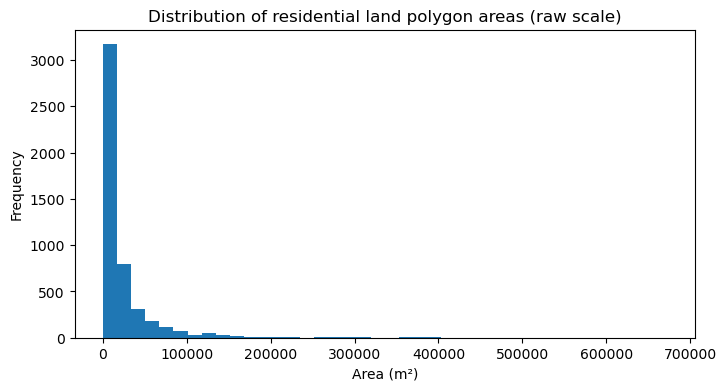

In [17]:
# polygon area in square meters
price["area_m2"] = price.geometry.area

x = price["area_m2"].to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(x, bins=40)
ax.set_title("Distribution of residential land polygon areas (raw scale)")
ax.set_xlabel("Area (m²)")
ax.set_ylabel("Frequency")
plt.show()


The distribution of polygon areas is highly right-skewed.  
Most residential price zones are relatively small, while a limited number of polygons cover very large areas, typically corresponding to peripheral or low-density residential zones.

This reflects the administrative and planning-based nature of the price map, where polygon size does not represent individual parcels but aggregated valuation zones.


### 5.2 Motivation for logarithmic transformation of area
The strong skewness of polygon areas implies that raw area values span several orders of magnitude.  
To improve interpretability and to align with subsequent regression-based modelling, a logarithmic transformation of polygon area is therefore introduced.



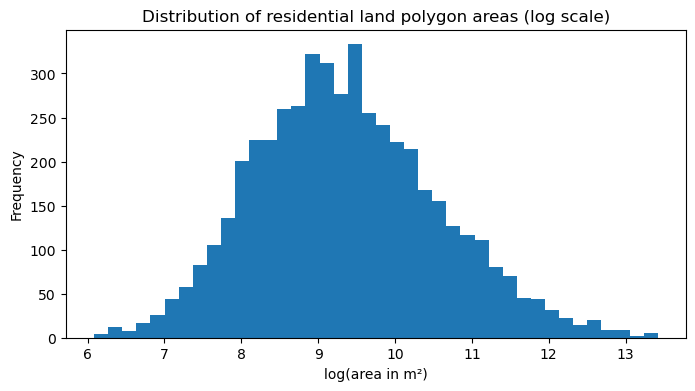

In [19]:
price["log_area_m2"] = np.log(price["area_m2"])

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(price["log_area_m2"], bins=40)
ax.set_title("Distribution of residential land polygon areas (log scale)")
ax.set_xlabel("log(area in m²)")
ax.set_ylabel("Frequency")
plt.show()


After logarithmic transformation, the distribution of polygon areas becomes substantially more symmetric and closely resembles a bell-shaped (approximately normal) distribution.  
This confirms that the extreme right-skewness observed in the raw area values is largely driven by a small number of very large residential zones.

Nevertheless, a mild right tail remains visible even after transformation.  
This suggests that a subset of residential polygons still represents unusually large spatial units, most likely corresponding to low-density or peripheral residential developments.  

The log-transformed area therefore improves statistical properties for modelling, while still preserving meaningful structural differences between central and peripheral residential zones.

Given this remaining asymmetry, polygon area is treated as a control variable rather than a primary explanatory factor in subsequent models.



### 5.3 Scatter plot: price vs. area (original scale)

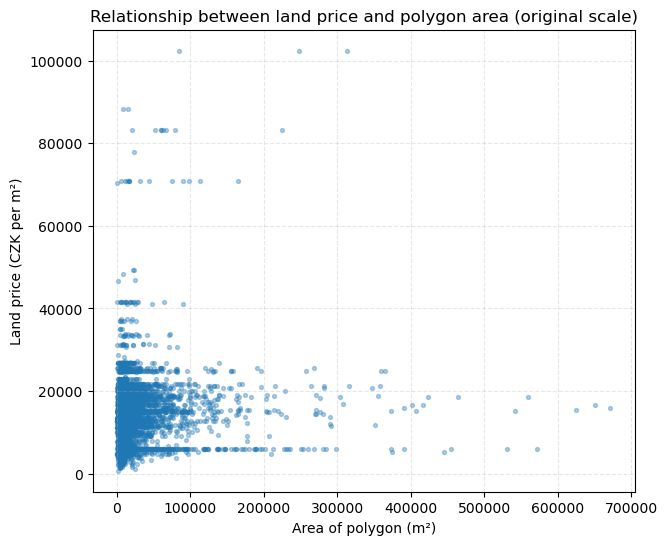

In [22]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.scatter(
    price["area_m2"],
    price["CENA_num"],
    s=8,
    alpha=0.35
)

ax.set_xlabel("Area of polygon (m²)")
ax.set_ylabel("Land price (CZK per m²)")
ax.set_title("Relationship between land price and polygon area (original scale)")

ax.grid(True, linestyle="--", alpha=0.3)
plt.show()


No interpretable relationship between polygon area and land price can be identified on the original scale. Though clustering pattern is significant with values strongly concentrating in the bottom left quadrant.

Horizontal bands reflect the stepwise structure of administratively defined land price zones.



### 5.4 Scatter plot: log(price) vs. log(area)

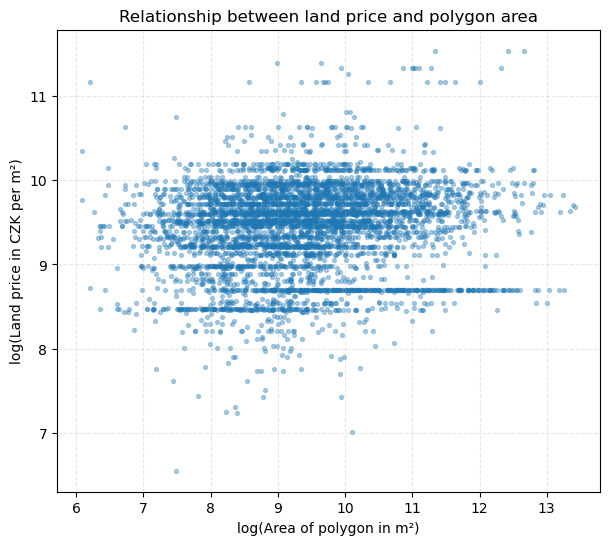

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# ensure numeric + log variables exist
price["log_price"] = np.log(price["CENA_num"])
price["area_m2"] = price.geometry.area
price["log_area"] = np.log(price["area_m2"])

fig, ax = plt.subplots(figsize=(7, 6))

ax.scatter(
    price["log_area"],
    price["log_price"],
    s=8,
    alpha=0.35
)

ax.set_xlabel("log(Area of polygon in m²)")
ax.set_ylabel("log(Land price in CZK per m²)")
ax.set_title("Relationship between land price and polygon area")

ax.grid(True, linestyle="--", alpha=0.3)
plt.show()


The scatter plot reveals no strong global relationship between polygon area and land price on logarithmic scale.
    
Even after logarithmic transformation, price variability remains high across the entire range of polygon sizes.

Although a weak trend can be visually perceived, the dispersion dominates the signal,
suggesting that polygon area alone provides little explanatory power.
    
The presence of horizontal bands reflects the discrete structure of the land price map,
where prices are assigned in stepwise zones rather than continuous values.

The lack of a clear price–area relationship suggests that location-specific factors,
rather than geometric characteristics of price zones, are the primary drivers of land value.


    

This visualization demonstrates that analysis on the original scale is not informative due to extreme skewness in both variables.
Logarithmic transformation is therefore necessary to reveal internal data structure and enable meaningful comparison.

Since neither polygon area nor its interaction with price explains the observed variability,
the next step is to explicitly test whether land prices exhibit spatial dependence.    


## Distance analysis

In [6]:
#Reloading dataset

gdf = gpd.read_file(PRICE_RES_PATH)

In [32]:
gdf.head()

,CENA,price_area,res_share,nearest_tram_id,dist_tram_m,nearest_metro_id,dist_metro_m,nearest_bus_id,dist_bus_m,nearest_rail_id,dist_rail_m,geometry
0,N,16907.977571,0.999709,U1006Z1,6510.948891,U50Z102,11774.645460,U520Z1,116.738833,U465Z301,2914.796661,"MULTIPOLYGON Z (((-746863.531 -1058380.267 0, ..."
1,4820,60966.997009,0.988428,U1006Z1,6405.502703,U50Z102,11690.993578,U520Z1,153.784774,U465Z301,2807.125832,"MULTIPOLYGON Z (((-746972.961 -1058097.797 0, ..."
2,12640,24667.166355,0.800901,U1006Z1,4824.076165,U258Z102,10031.651288,U1039Z1,364.717407,U465Z301,1395.391927,"MULTIPOLYGON Z (((-747150.551 -1056468.532 0, ..."
3,1110,24489.516479,0.944726,U1006Z1,6293.474144,U258Z102,11006.239543,U1701Z1,211.739928,U465Z301,2846.516720,"MULTIPOLYGON Z (((-748097.541 -1057567.507 0, ..."
4,9100,12616.228897,0.999328,U1006Z1,6015.800365,U258Z102,10735.595069,U14Z1,190.686843,U465Z301,2602.727230,"MULTIPOLYGON Z (((-747923.471 -1057300.142 0, ..."


In [33]:
dist_cols = [
    "dist_tram_m",
    "dist_metro_m",
    "dist_bus_m",
    "dist_rail_m"
]

gdf[dist_cols].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])


,dist_tram_m,dist_metro_m,dist_bus_m,dist_rail_m
count,5728.000000,5728.000000,5728.000000,5728.000000
mean,1768.927036,2236.504792,189.105577,1431.681705
std,1992.466041,2167.168391,134.342420,944.889550
min,3.485493,3.399639,1.489560,36.998195
10%,140.823209,354.201694,57.458433,430.395774
25%,298.296569,659.385275,96.537477,780.538949
50%,930.737293,1489.787826,159.358706,1247.226729
75%,2619.594500,3020.905570,242.748386,1819.081960
90%,4576.453793,5287.954465,354.400567,2697.475936
max,10723.837338,11774.645460,1480.158478,6474.395420


Descriptive statistics of distance-to-stop variables show clear differences in scale and dispersion across transport modes. 

Bus stop distances are consistently low, with a median around 160 m and a narrow interquartile range, indicating very limited variability across the study area. 

Tram and metro distances exhibit substantially higher medians and much wider spreads, with strongly right-skewed distributions and long upper tails extending beyond 10 km. 

Metro distances are generally larger than tram distances across all quantiles, reflecting a sparser spatial structure. 

Rail distances fall between tram and metro in terms of central tendency, while displaying a shorter upper tail than metro. 

Across all modes, minimum distances are close to zero, while upper quantiles vary strongly, suggesting heterogeneous spatial coverage rather than uniform accessibility.

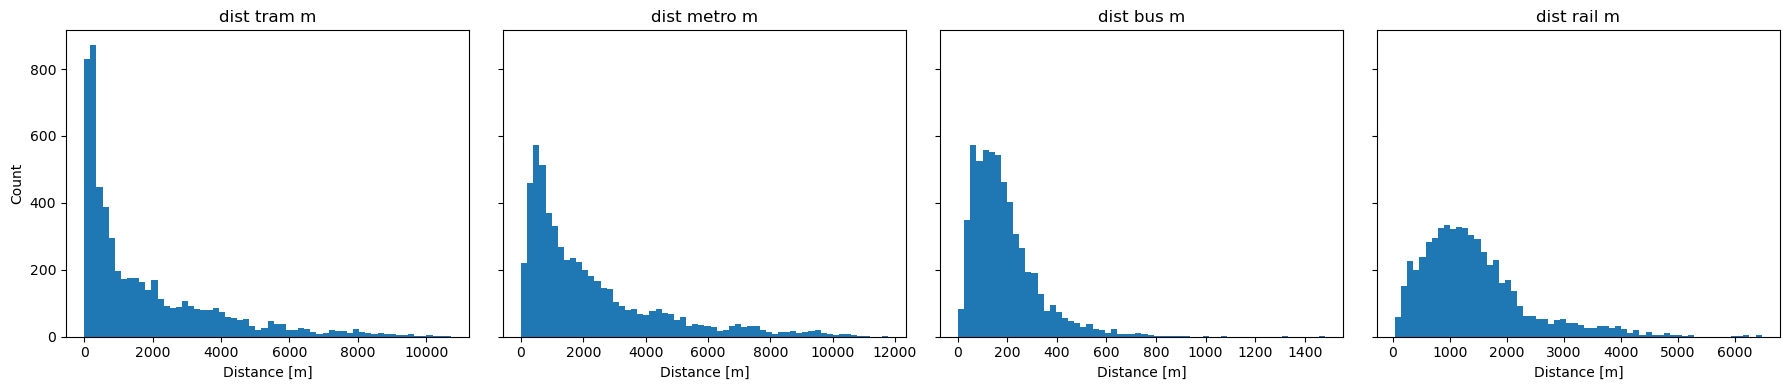

In [34]:
import matplotlib.pyplot as plt

DIST_COLS = [
    "dist_tram_m",
    "dist_metro_m",
    "dist_bus_m",
    "dist_rail_m"
]

fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(18, 4),
    sharey=True
)

for ax, col in zip(axes, DIST_COLS):
    ax.hist(
        gdf[col].dropna(),
        bins=60
    )
    ax.set_title(col.replace("_", " "))
    ax.set_xlabel("Distance [m]")

axes[0].set_ylabel("Count")

plt.tight_layout()
plt.show()


All distance-to-stop variables exhibit strongly right-skewed distributions with long upper tails, indicating that a large share of observations is concentrated at relatively short distances while a smaller number extends to much larger values. 

Given the strongly right-skewed distributions of all distance variables, a logarithmic transformation provides a natural and parsimonious way to stabilise scale while preserving interpretability. 

Unlike more flexible power transformations, log(distance) retains a clear and intuitive meaning in terms of relative accessibility, where proportional changes in distance correspond to comparable shifts in spatial context. 

This is particularly important for practical interpretation, as differences between 100 and 200 metres carry a different qualitative meaning than differences between 2 and 3 kilometres. 

Using a common logarithmic transformation across transport modes also ensures consistency and comparability, while capturing the main distributional features observed in the data without introducing mode-specific or hard-to-interpret transformations.

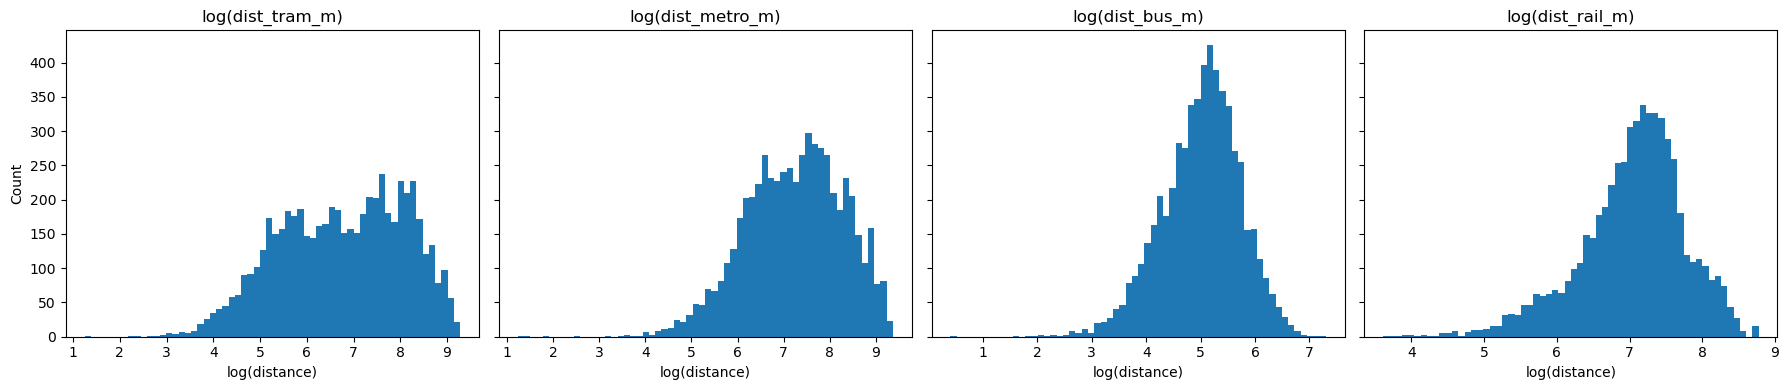

In [37]:
import numpy as np
import matplotlib.pyplot as plt

DIST_COLS = [
    "dist_tram_m",
    "dist_metro_m",
    "dist_bus_m",
    "dist_rail_m"
]

fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(18, 4),
    sharey=True
)

for ax, col in zip(axes, DIST_COLS):
    log_data = np.log(gdf[col].dropna())

    ax.hist(
        log_data,
        bins=60
    )
    ax.set_title(f"log({col})")
    ax.set_xlabel("log(distance)")

axes[0].set_ylabel("Count")

plt.tight_layout()
plt.show()


After applying a logarithmic transformation, the distance distributions become markedly more regular and comparable across transport modes. 

The extreme right tails observed on the linear scale are compressed, revealing smoother and more symmetric shapes that expose the internal structure of accessibility rather than being dominated by a small number of large distances. 

The log-distance distributions indicate that observed distances are not random but reflect distinct network regimes created by planned transport systems and urban structure. 

Each mode exhibits a characteristic accessibility range: buses provide uniform baseline coverage, trams structure local corridors, metro functions as a hierarchical backbone connecting key nodes, and rail operates as a more selective, node-based system. 

These differences appear as stable, mode-specific distribution shapes on the log scale, highlighting qualitative rather than purely quantitative differences in accessibility. 

This supports the use of log(distance) as a common, interpretable representation for comparing transport modes.

### Scatter plots against price

In [40]:
PRICE_COL = "price_area"
LOG_PRICE_COL = "log_price_m2"

DIST_COLS = [
    "dist_tram_m",
    "dist_metro_m",
    "dist_bus_m",
    "dist_rail_m"
]


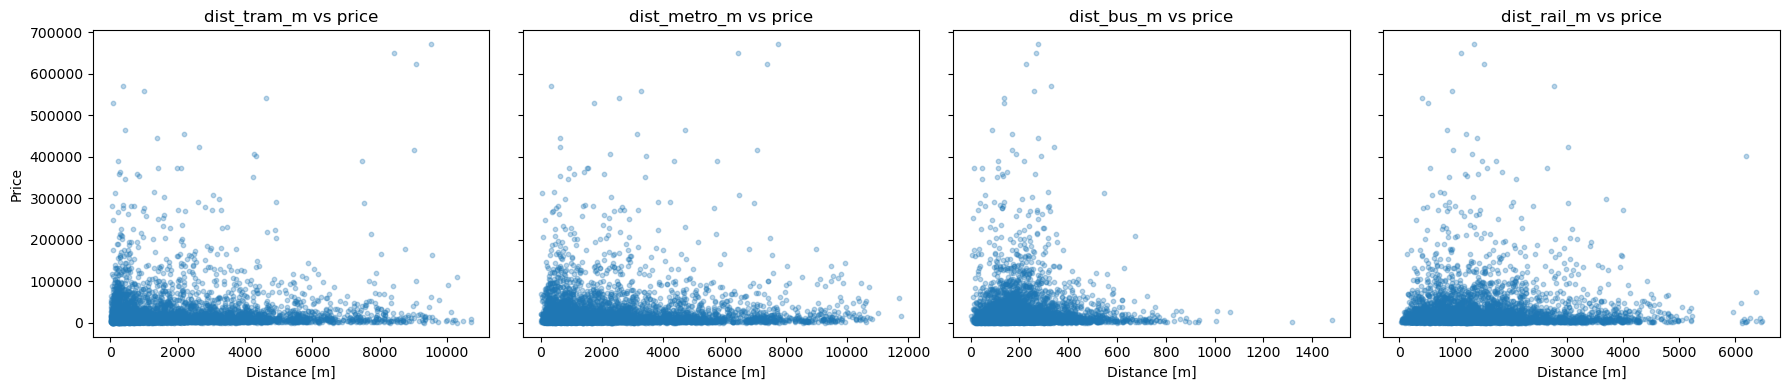

In [41]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(18, 4),
    sharey=True
)

for ax, col in zip(axes, DIST_COLS):
    ax.scatter(
        gdf[col],
        gdf[PRICE_COL],
        s=10,
        alpha=0.3
    )
    ax.set_title(f"{col} vs price")
    ax.set_xlabel("Distance [m]")

axes[0].set_ylabel("Price")

plt.tight_layout()
plt.show()


Scatter plots of distance versus raw prices are dominated by heteroskedasticity and extreme values, obscuring any systematic structure and motivating analysis on logarithmic scales.

Scatter plots: log(distance) × log(price)

In [7]:
import numpy as np
import pandas as pd

PRICE_COL = "CENA"

# Convert to numeric, invalid values → NaN
price_num = pd.to_numeric(gdf[PRICE_COL], errors="coerce")


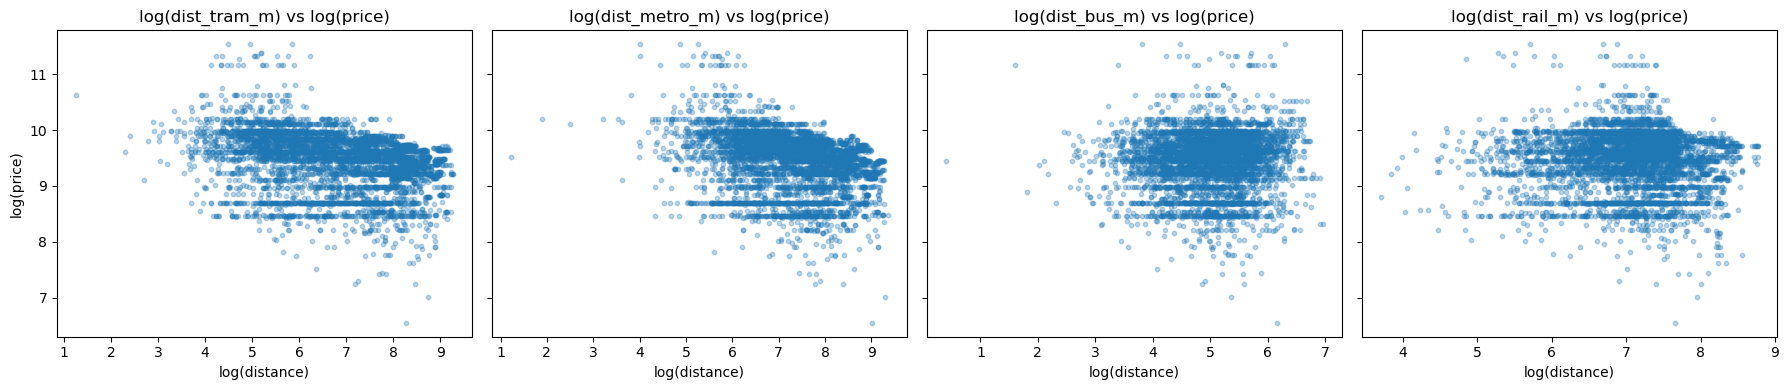

In [8]:
import matplotlib.pyplot as plt

DIST_COLS = [
    "dist_tram_m",
    "dist_metro_m",
    "dist_bus_m",
    "dist_rail_m"
]

fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(18, 4),
    sharey=True
)

for ax, col in zip(axes, DIST_COLS):
    # Jointly drop missing / invalid values
    mask = (~price_num.isna()) & (~gdf[col].isna()) & (price_num > 0)
    data = gdf.loc[mask, col]
    prices = price_num.loc[mask]

    log_dist = np.log(data)
    log_price = np.log(prices)

    ax.scatter(
        log_dist,
        log_price,
        s=10,
        alpha=0.3
    )
    ax.set_title(f"log({col}) vs log(price)")
    ax.set_xlabel("log(distance)")

axes[0].set_ylabel("log(price)")

plt.tight_layout()
plt.show()


When both distance and price are expressed on logarithmic scales, a clear and stable structure emerges across all transport modes. 

The relationship manifests primarily as a declining upper envelope, indicating that accessibility acts as a constraining condition on maximum prices rather than a determinant of average values.

The shape and clarity of this envelope differ by mode, with metro exhibiting the strongest and most coherent hierarchical pattern, tram showing more localised structure, bus displaying weak discrimination, and rail reflecting a selective, node-based effect. 

These patterns suggest the presence of distinct accessibility regimes and motivate further spatial exploration rather than immediate model fitting.

To explore whether the relationship between accessibility and prices is homogeneous across space or structured into distinct regimes, the scatter plots are further stratified by distance quantiles. 

Rather than treating distance as a single continuous variable, this approach allows the data to be examined in relative accessibility bands, highlighting potential threshold effects and regime shifts that may be obscured in aggregate views. 

Coloring observations by quantiles provides a rapid, assumption-light way to detect whether different ranges of distance correspond to systematically different price patterns, and whether proximity primarily affects the upper envelope, dispersion, or overall structure of the relationship.

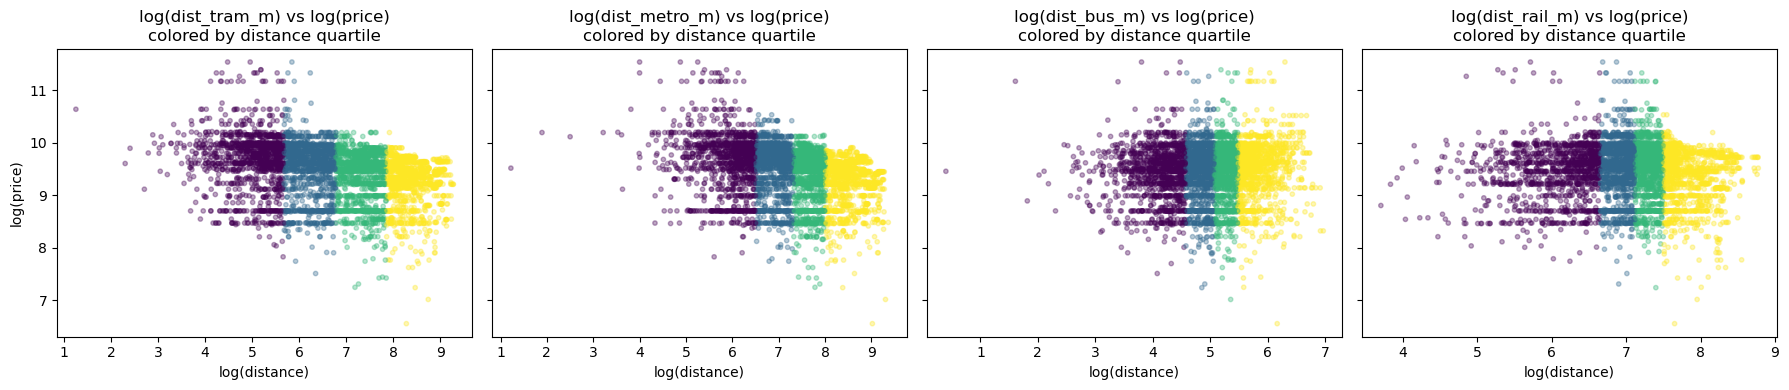

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PRICE_COL = "CENA"  # adjust
DIST_COLS = ["dist_tram_m", "dist_metro_m", "dist_bus_m", "dist_rail_m"]

# Price as numeric (string -> float), invalid -> NaN
price_num = pd.to_numeric(gdf[PRICE_COL], errors="coerce")

# Work on log-log values on the fly
log_price = np.log(price_num)

fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=True)

for ax, dist_col in zip(axes, DIST_COLS):
    mask = (~price_num.isna()) & (price_num > 0) & (~gdf[dist_col].isna()) & (gdf[dist_col] > 0)
    tmp = gdf.loc[mask, [dist_col]].copy()
    tmp["log_dist"] = np.log(tmp[dist_col])
    tmp["log_price"] = log_price.loc[mask]

    # Distance quartiles (0..3)
    tmp["q"] = pd.qcut(tmp[dist_col], 4, labels=False)

    sc = ax.scatter(
        tmp["log_dist"],
        tmp["log_price"],
        c=tmp["q"],
        s=10,
        alpha=0.35
    )

    ax.set_title(f"log({dist_col}) vs log(price)\ncolored by distance quartile")
    ax.set_xlabel("log(distance)")

axes[0].set_ylabel("log(price)")
plt.tight_layout()
plt.show()


Coloring the log–log scatter plots by distance quantiles reveals that accessibility operates through distinct regimes rather than as a single continuous gradient. 

Across all modes, successive distance quantiles exhibit systematically declining upper price envelopes, while lower price levels remain largely unaffected. 

The effect is weakest for buses, where quantiles largely overlap, and strongest for metro and rail, where clear hierarchical separation emerges. 

This pattern suggests that proximity to higher-order transport infrastructure primarily constrains maximum attainable prices and delineates accessibility regimes rather than uniformly shifting price levels.

### Spatial distribution of accessibility variables

To link the distance-based regimes observed in scatter plots with the actual urban structure, the analysis now shifts to the spatial distribution of accessibility measures.

While the coloured scatter plots reveal clear distance-based regimes in the price–accessibility relationship, they abstract away from the geographical structure of the city. 

Introducing spatial visualisation allows these regimes to be anchored in physical space, making it possible to assess whether the observed patterns correspond to coherent urban areas, infrastructure corridors, or historical development layers. 

Mapping the spatial distribution of accessibility therefore provides critical context for interpreting the scatter-based findings, helps identify large-scale gradients and local discontinuities, and clarifies how different transport modes structure the city in geographical terms rather than only in statistical space.

In [28]:
import numpy as np
import pandas as pd

DIST_COLS = ["dist_tram_m", "dist_metro_m", "dist_bus_m", "dist_rail_m"]

# Ensure distances are numeric (in case they are strings)
for col in DIST_COLS:
    price[col] = pd.to_numeric(price[col], errors="coerce")

# Log-transform (safe: +1 avoids issues with zeros)
for col in DIST_COLS:
    price[f"log_{col}"] = np.log(price[col] + 1)

#### Spatial distribution of nearest tram stop distance

In [ ]:
price.explore(
    column="log_dist_tram_m",
    cmap="viridis",
    scheme="quantiles",
    k=7,
    tooltip=["dist_tram_m", "log_dist_tram_m"],
    legend=True,
    tiles="CartoDB positron",
    style_kwds={"weight": 0.2, "opacity": 0.6}
)


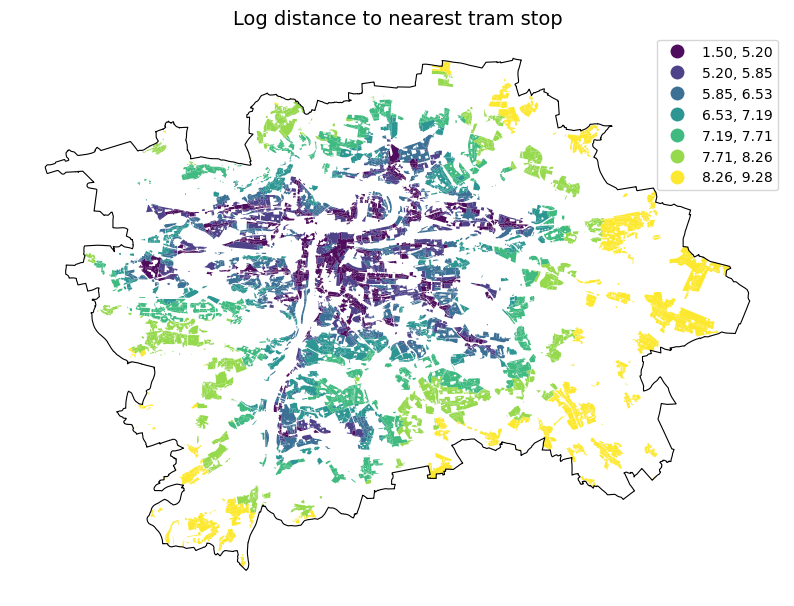

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Optional: plot Prague boundary if you want consistency
boundary.boundary.plot(
    ax=ax,
    linewidth=0.8,
    color="black",
    zorder=2
)

# Plot log distance to tram
price.plot(
    ax=ax,
    column="log_dist_tram_m",
    cmap="viridis",
    scheme="quantiles",
    k=7,
    legend=True,
    linewidth=0.0,
    alpha=0.95,
    zorder=1
)

ax.set_title("Log distance to nearest tram stop", fontsize=14)
ax.axis("off")

plt.show()


The map shows that tram accessibility is organised along linear corridors rather than radially, creating distinct spatial regimes that align with the network structure and explain the regime patterns observed in the scatter plots.

#### Spatial distribution of nearest metro stop distance

In [ ]:
price.explore(
    column="log_dist_metro_m",
    cmap="viridis",
    scheme="quantiles",
    k=7,
    tooltip=["dist_metro_m", "log_dist_metro_m"],
    legend=True,
    tiles="CartoDB positron",
    style_kwds={"weight": 0.2, "opacity": 0.6}
)


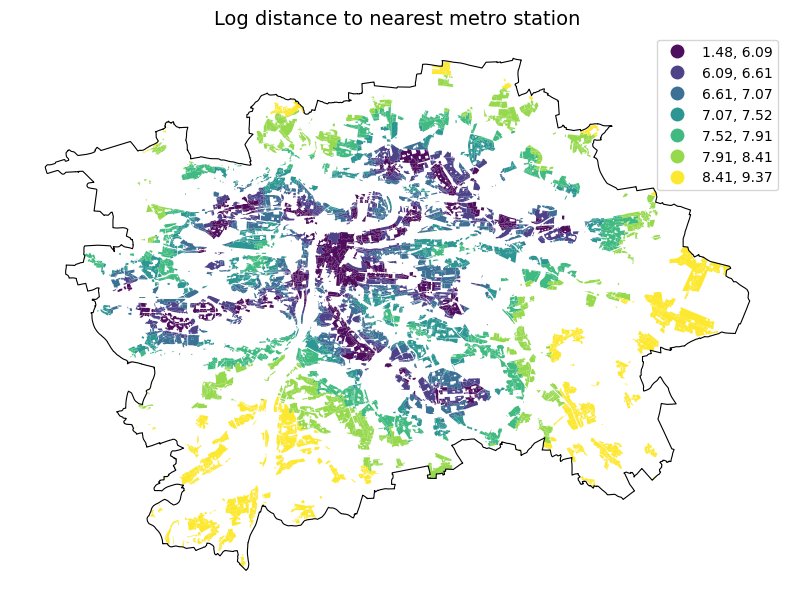

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Optional: Prague administrative boundary
boundary.boundary.plot(
    ax=ax,
    linewidth=0.8,
    color="black",
    zorder=2
)

# Plot log distance to nearest metro
price.plot(
    ax=ax,
    column="log_dist_metro_m",
    cmap="viridis",
    scheme="quantiles",
    k=7,
    legend=True,
    linewidth=0.0,
    alpha=0.95,
    zorder=1
)

ax.set_title("Log distance to nearest metro station", fontsize=14)
ax.axis("off")

plt.show()


Metro accessibility follows a broad centre–periphery gradient, forming wide zones of influence rather than narrow corridors and reinforcing the city’s hierarchical spatial structure.

The spatial distribution of log-transformed distances to the nearest metro station exhibits a clear large-scale accessibility gradient structured around the historical core of the city. 

Areas with the lowest distances are concentrated in the inner city and along the primary metro corridors, while accessibility gradually decreases with increasing distance from the centre. 

Unlike the tram network, metro accessibility does not form narrow linear corridors but rather broad zones of influence, reflecting its role as a hierarchical backbone connecting key urban nodes. 

Peripheral areas, particularly in the eastern and south-eastern parts of the city, display consistently higher distances, highlighting the limits of metro coverage and reinforcing the centre–periphery structure observed in the scatter-based regime analysis.

#### Spatial distribution of nearest bus stop distance

In [ ]:
price.explore(
    column="log_dist_bus_m",
    cmap="viridis",
    scheme="quantiles",
    k=7,
    tooltip=["dist_bus_m", "log_dist_bus_m"],
    legend=True,
    tiles="CartoDB positron",
    style_kwds={"weight": 0.2, "opacity": 0.6}
)


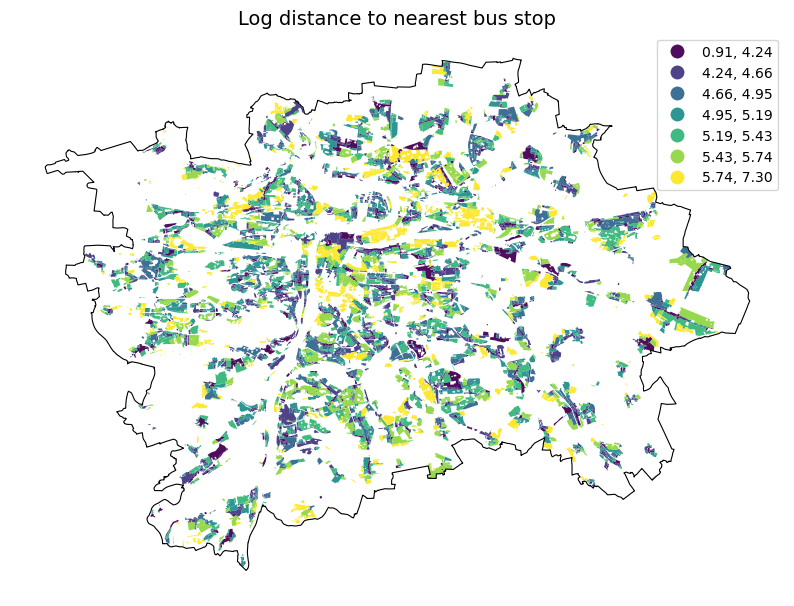

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Optional: Prague administrative boundary
boundary.boundary.plot(
    ax=ax,
    linewidth=0.8,
    color="black",
    zorder=2
)

# Plot log distance to nearest bus stop
price.plot(
    ax=ax,
    column="log_dist_bus_m",
    cmap="viridis",
    scheme="quantiles",
    k=7,
    legend=True,
    linewidth=0.0,
    alpha=0.95,
    zorder=1
)

ax.set_title("Log distance to nearest bus stop", fontsize=14)
ax.axis("off")

plt.show()


Bus accessibility is spatially diffuse and weakly structured, reflecting a dense coverage-oriented network rather than corridor-based or hierarchical accessibility patterns.

The spatial distribution of log-transformed distances to the nearest bus stop differs fundamentally from the patterns observed for metro and tram. 

Rather than forming coherent corridors or large-scale gradients, low bus distances are scattered across almost the entire urban area, resulting in a fragmented and weakly structured spatial pattern. 

This reflects the dense, coverage-oriented nature of the bus network, which is designed to minimise local accessibility gaps rather than to impose a clear spatial hierarchy. 

As a result, bus accessibility varies primarily at a very local scale and does not delineate broad accessibility regimes, explaining why distance to bus stops exhibits limited discriminatory power in the scatter-based analysis.

#### Spatial distribution of nearest rail stop distance

In [ ]:
price.explore(
    column="log_dist_rail_m",
    cmap="viridis",
    scheme="quantiles",
    k=7,
    tooltip=["dist_rail_m", "log_dist_rail_m"],
    legend=True,
    tiles="CartoDB positron",
    style_kwds={"weight": 0.2, "opacity": 0.6}
)


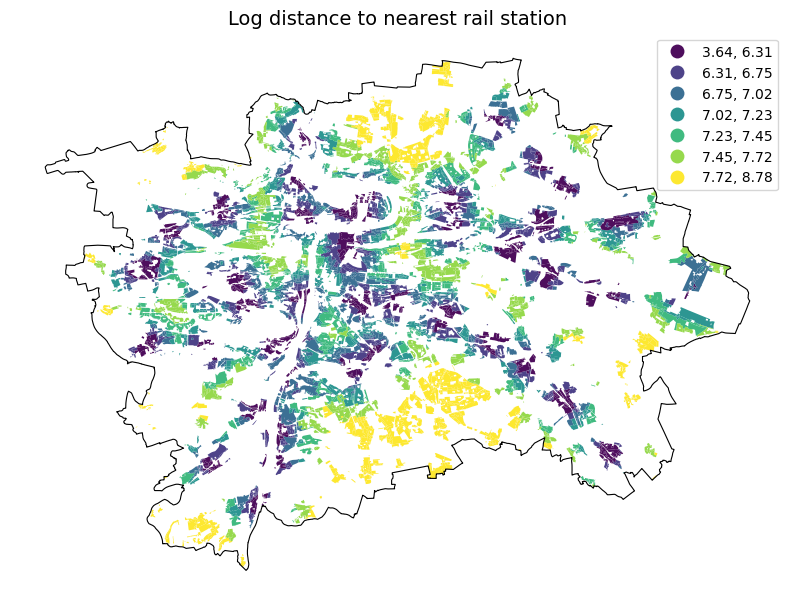

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Optional: Prague administrative boundary
boundary.boundary.plot(
    ax=ax,
    linewidth=0.8,
    color="black",
    zorder=2
)

# Plot log distance to nearest rail stop
price.plot(
    ax=ax,
    column="log_dist_rail_m",
    cmap="viridis",
    scheme="quantiles",
    k=7,
    legend=True,
    linewidth=0.0,
    alpha=0.95,
    zorder=1
)

ax.set_title("Log distance to nearest rail station", fontsize=14)
ax.axis("off")

plt.show()


Rail accessibility exhibits a selective, node-based spatial pattern concentrated around station corridors, reflecting its role in suburban and regional commuting rather than continuous urban coverage.

### Conclusion of Exploratory analysis

The exploratory analysis demonstrates that the relationship between residential prices and public transport accessibility is neither linear nor homogeneous, but structured through distinct accessibility regimes that operate on relative rather than absolute scales. 

Logarithmic transformations of both distance and price reveal stable patterns across transport modes, where accessibility primarily constrains the upper envelope of prices instead of shifting average values. 

Scatter plots coloured by distance quantiles further show that proximity functions through regime membership—successive accessibility bands exhibit systematically different price ceilings—indicating threshold-like behaviour rather than smooth gradients.


Mapping the spatial distribution of accessibility measures anchors these statistical patterns in the physical structure of the city and confirms their network-specific origins. 

Metro accessibility follows a broad centre–periphery gradient consistent with its hierarchical backbone role, tram accessibility forms corridor-based regimes aligned with linear urban structure, bus accessibility appears spatially diffuse and weakly discriminatory, and rail accessibility is highly selective and node-based, reflecting suburban and regional commuting patterns. 

Together, these findings show that accessibility effects are mode-specific, spatially embedded, and historically conditioned, suggesting that any subsequent modelling must explicitly account for non-linearity, regime structure, and the differing functional roles of transport modes rather than treating distance as a uniform continuous predictor.

The exploratory analysis indicates that accessibility effects operate on relative, non-linear scales and differ systematically across transport modes. 

Logarithmic transformations improve interpretability and reveal regime-like behaviour, where proximity primarily constrains upper price levels rather than shifting averages. 

These findings motivate model specifications that treat distance effects as diminishing and mode-specific, and that prioritise flexible functional forms over simple linear relationships.